## Recommend top 5 books for any selected user based on model trained using neural networks. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#!pip install -q kaggle
#!pip install -q kaggle-cli

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for lxml
  error: subprocess-exited-with-error
  
  × Running setup.py install for lxml did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: 

In [4]:
# This works only on Google Colab where I did it. 
import os
os.environ['KAGGLE_USERNAME'] = "raghavgovindjha" 
os.environ['KAGGLE_KEY'] = "2b64c6d2931ac13a624689d252191dbathisisakeydontcopy"

In [5]:
!kaggle datasets download -d zygmunt/goodbooks-10k --unzip

 43% 5.00M/11.6M [00:00<00:00, 46.7MB/s]
100% 11.6M/11.6M [00:00<00:00, 87.3MB/s]


In [6]:
dataset = pd.read_csv('ratings.csv')

In [7]:
dataset.head(5)

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [8]:
dataset.shape

(981756, 3)

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=11)

In [11]:
n_users = len(dataset.user_id.unique())
n_books = len(dataset.book_id.unique())
n_users, n_books

(53424, 10000)

Create a dot product model. A dot product of user feasture and respective book featur is taken.

In [15]:
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)
book_vec

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Flatten-Books')>

In [16]:
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

Do a dot product now.

In [21]:
# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

Epoch 1/3
24544/24544 [==============================] - 156s 6ms/step - loss: 2.1160
Epoch 2/3
24544/24544 [==============================] - 151s 6ms/step - loss: 1.2906
Epoch 3/3
24544/24544 [==============================] - 159s 6ms/step - loss: 1.0075


Text(0, 0.5, 'Training Error')

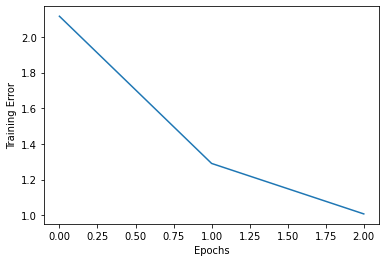

In [25]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=3, verbose=1)
model.save('Regression_model.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

I did epochs=3 because it was taking time. Try epochs=5 or more if it runs faster on your machine. 

In [28]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])
for i in range(0,10):
  print(predictions[i], test.rating.iloc[i])

1/1 [==============================] - 0s 43ms/step
[3.613168] 4
[3.174718] 3
[3.3264792] 4
[4.582806] 3
[3.8351033] 3
[4.6743097] 5
[3.2267015] 4
[3.801266] 3
[3.9908907] 4
[4.1160526] 4


The first model we used had some training loss. We can try 
another model based on neural networks which are useful for 
recommendation systems. We will use two dense layers with 
RELU activation function. We will run it for 2 epochs and see whether if goes below 1.25 ish (for dot product model) .. 

In [29]:
# Concatenate features
conc = Concatenate()([book_vec, user_vec])

# Add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile('adam', 'mean_squared_error')

Epoch 1/2
24544/24544 [==============================] - 176s 7ms/step - loss: 0.7222
Epoch 2/2
24544/24544 [==============================] - 172s 7ms/step - loss: 0.6523


Text(0, 0.5, 'Training Error')

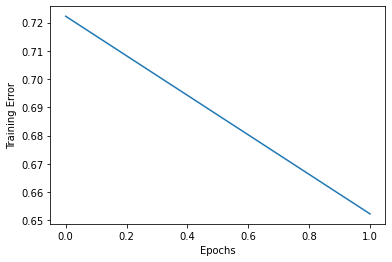

In [30]:
from keras.models import load_model
history = model2.fit([train.user_id, train.book_id], train.rating, epochs=2, verbose=1)
model2.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

It does better! Recommender systems are very popular and commercially interesting. Add to this the fact that the world
will cross 175 ZB limit of total data by 2025! 

One can use use matrix factorization methods, see this:
https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf

In [31]:
model2.evaluate([test.user_id, test.book_id], test.rating)

6136/6136 [==============================] - 11s 2ms/step - loss: 0.7223


0.7222829461097717

In [35]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 5)

The shape of the book embedding layer is (10001, 5). This means that the network has been able to map each book to a 5 column vector! 

In [36]:
# Print some 

book_em_weights[:5]

array([[-0.02303454,  0.02930451, -0.00347271,  0.02737523, -0.00672765],
       [-1.913257  , -0.49479362,  1.9359299 , -0.28429198, -1.3956783 ],
       [-1.670049  , -0.49995342,  1.5282073 , -1.0113492 , -1.4197067 ],
       [-0.70537394, -0.1460928 ,  1.1280104 ,  0.22369295, -0.28602502],
       [-1.7583412 , -0.10453407,  1.7263246 , -1.2805681 , -1.791764  ]],
      dtype=float32)

We will do PCA to 2 components to reduce 5 -> 2 further just because we can.

---



<AxesSubplot:>

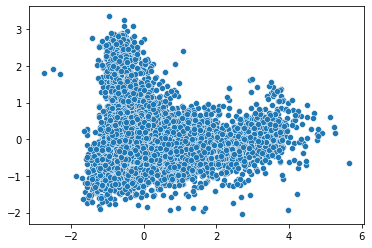

In [37]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

Now we can make recommendation for a given user. Let's do this!

In [47]:
# Creating dataset for making recommendations for user

book_data = np.array(list(set(dataset.book_id)))
book_data[:5]



array([1, 2, 3, 4, 5])

In [48]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [49]:
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:5]
# The minus is becuase of what .argsort does: 
# x = np.array([3, 1, 2]), np.argsort(x) returns array([1, 2, 0])
# So we want reverse of it. Highest predictions
recommended_book_ids

313/313 [==============================] - 1s 2ms/step


array([9530, 7946, 9565, 9841, 8232])

In [50]:
# Print predicted scores

predictions[recommended_book_ids]

array([2.8853254, 2.8692832, 2.8290129, 2.780881 , 2.7784894],
      dtype=float32)

In [51]:
books = pd.read_csv('books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [52]:
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
7945,7946,39926,39926,836516,43,60512180,9.780061e+12,Naomi Wolf,1990.0,The Beauty Myth: How Images of Beauty Are Used...,...,13037,14266,790,234,790,3493,5552,4197,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
8231,8232,10395,10395,13106,31,60731427,9.780061e+12,Franklin Foer,2004.0,How Soccer Explains the World: An Unlikely The...,...,9231,9944,716,246,669,2794,3715,2520,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9529,9530,139176,139176,901444,53,312939167,9.780313e+12,M.C. Beaton,1992.0,Agatha Raisin and the Quiche of Death,...,10925,13409,1325,222,801,4148,5113,3125,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9564,9565,24819476,24819476,44460264,18,316261130,9.780316e+12,Elin Hilderbrand,2015.0,Winter Stroll,...,8397,9754,979,133,640,3133,3971,1877,https://images.gr-assets.com/books/1431957489m...,https://images.gr-assets.com/books/1431957489s...
9840,9841,15101,15101,876908,55,380815923,9.780381e+12,Joanne Harris,1999.0,Blackberry Wine,...,9558,11107,699,163,755,3215,4220,2754,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


Now, this is what we get to. The final result. It will be interesting to see what happens if we train more. Does this change? If yes, by how much? 